In [133]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as Model #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model
from advectionGP.wind import WindFixU, WindSimple #Wind model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(6,9,4) # lower time
xloc=np.linspace(7.5,8.5,4) # x locations
yloc=np.linspace(7.5,8.5,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [134]:
# Run forward model to generate concentration
#u = [0.05,0.] #Advection


k_0 = 0.02 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=100 # number of features used to approximate ground truth GP
boundary = ([5,5,5],[10,10,10])# corners of the grid - in units of space
k = EQ(1.0, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.05
u=[]
#u.append(0*np.ones(res)*wind) #x direction wind
#u.append(0*np.ones(res)*0.0) # y direction wind
#windmodel=WindFixU(u) # establish fixed wind model
windmodel=WindSimple(0.35,0.35)
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
source=(m.computeSourceFromPhi(z)) # Compute source
#source[source<0]=0

#source = np.zeros(m.resolution)
##source[0,int(Nx/2)-1,int(Ny/2)-1] = 10.0
#source[:,15:25,15:25] = 5
#source[:,2:7,2:7] = 25
#source[:,7:12,15:20] = 25
#source[:,18:28,10:20] = 25

concTrain=m.computeConcentration(source) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations
concTrainNN=m.computeConcentration(source,enforce_nonnegative=True) # Compute concentration - runs advection diffusion forward model
yTrainNN= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations


In [135]:
N_feat = 100 #Number of features used to infer the source
k = EQ(1.0, 2.0) 
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
#%timeit -n1 -r1 regress = mInfer.computeModelRegressors() # Compute regressor matrix

In [136]:
from time import time

In [137]:
"""
Computes the regressor matrix X, using getHs from the sensor model and getPhi from the kernel.
X here is used to infer the distribution of z (and hence the source).
X is [features x observations]
"""
dt,dx,dy,dx2,dy2,Nt,Nx,Ny = mInfer.getGridStepSize()
designMatrixX = np.zeros([mInfer.N_feat,len(mInfer.sensormodel.obsLocs)])

adjs = []
st = time()
for j,H in enumerate(mInfer.sensormodel.getHs(mInfer)):
    pass
print("getHs (all)           %6.1fms" % (1e3*(time()-st)))

st = time()
mInfer.computeAdjoint(H)
print("computeAdjoint (once) %6.1fms" % (1e3*(time()-st)))


st = time()
#O(GN)
for j,H in enumerate(mInfer.sensormodel.getHs(mInfer)):
    adjs.append(mInfer.computeAdjoint(H))
print("getHs & comp.Adjoints %6.1fms" % (1e3*(time()-st)))

st = time()
for i,phi in enumerate(mInfer.kernel.getPhi(mInfer.coords)):
    pass
print("getPhis               %6.1fms" % (1e3*(time()-st)))

st = time()
#O(GNF)
for i,phi in enumerate(mInfer.kernel.getPhi(mInfer.coords)):
    for j,adj in enumerate(adjs):
        designMatrixX[i,j] = np.sum((phi*adj))*dt*dx*dy
        
print("getPhis and products  %6.1fms" % (1e3*(time()-st)))
#phi * v, --> scale

getHs (all)              5.5ms
computeAdjoint (once)   35.9ms
getHs & comp.Adjoints 1464.2ms
getPhis                215.1ms
getPhis and products  1050.2ms


In [174]:
def getPhiValues(kernel,particles):
    c=1/(kernel.l2)
    norm = 1./np.sqrt(kernel.N_feat)
    return norm*np.sqrt(2*kernel.sigma2)*np.cos(c*np.einsum('ij,lkj',kernel.W,particles)+kernel.b[:,None,None])

st = time()
Nsamps = 100
scale = Nsamps / dt

particles = []
N_obs = len(mInfer.sensormodel.obsLocs)
for obsi in range(N_obs):
    locA = mInfer.sensormodel.obsLocs[obsi,[0,2,3]]
    locB = mInfer.sensormodel.obsLocs[obsi,[1,2,3]]
    newparticles = np.repeat(locA[None,:],Nsamps,0)
    newparticles[:,0]+=np.random.rand(len(newparticles))*(locB[0]-locA[0])
    particles.append(newparticles)
particles = np.array(particles)

newX = np.zeros([N_feat,N_obs])
for nit in range(500):#+int(locB[0]/dt)):
    wind = windmodel.getwind(particles[:,:,1:])*dt #how much each particle moves due to wind [backwards]
    particles[:,:,1:]+=np.random.randn(particles.shape[0],particles.shape[1],2)*np.sqrt(2*dt*mInfer.k_0) - wind
    particles[:,:,0]-=dt
    
    keep = particles[:,0,0]>mInfer.boundary[0][0] #could extend to be within grid space
    newX[:,keep] += np.sum(getPhiValues(mInfer.kernel,particles),axis=(1))[:,keep]
    if np.sum(keep)==0: 
        break
newX = np.array(newX)/scale
print("run new particle method  %6.1fms" % (1e3*(time()-st)))

run new particle method  1382.9ms


(array([   4.,  104.,  321.,  662., 2337., 2051.,  585.,  195.,  136.,
           5.]),
 array([-0.17230025, -0.13718317, -0.10206608, -0.066949  , -0.03183192,
         0.00328516,  0.03840224,  0.07351932,  0.1086364 ,  0.14375348,
         0.17887056]),
 <a list of 10 Patch objects>)

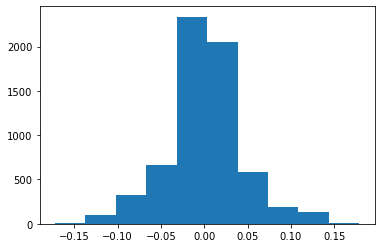

In [175]:
#assumed fixed:
#griderrorscale = np.sum(next(mInfer.sensormodel.getHs(mInfer)))*(dt*dx*dy)
#print(griderrorscale)

plt.hist(newX.flatten()-designMatrixX.flatten())#,np.arange(0,4,0.1)); 

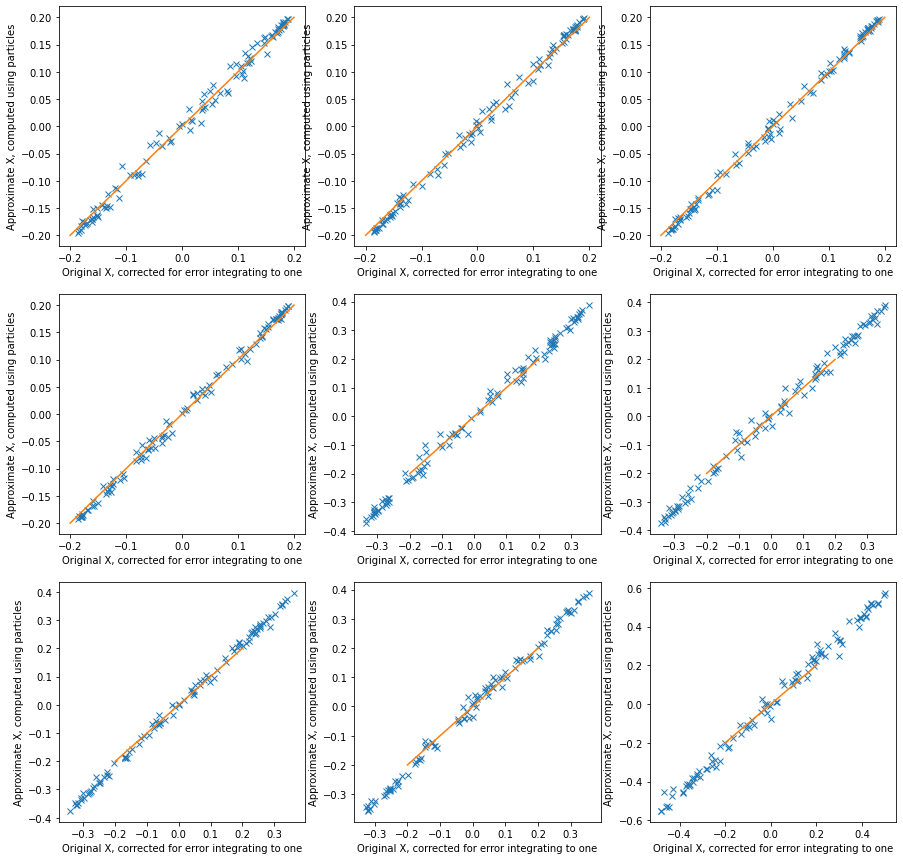

In [176]:
plt.figure(figsize=[15,15])
for plti in range(9):
    plt.subplot(3,3,plti+1)
    plt.plot(designMatrixX[:,plti],newX[:,plti],'x')
    plt.xlabel('Original X, corrected for error integrating to one')
    plt.ylabel('Approximate X, computed using particles')
    plt.plot([-0.2,0.2],[-0.2,0.2])

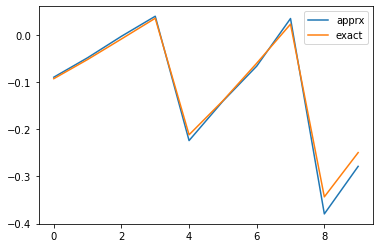

In [177]:
plt.plot(newX.T[:10,5],label='apprx')
plt.plot(designMatrixX.T[:10,5],label='exact')
plt.legend()

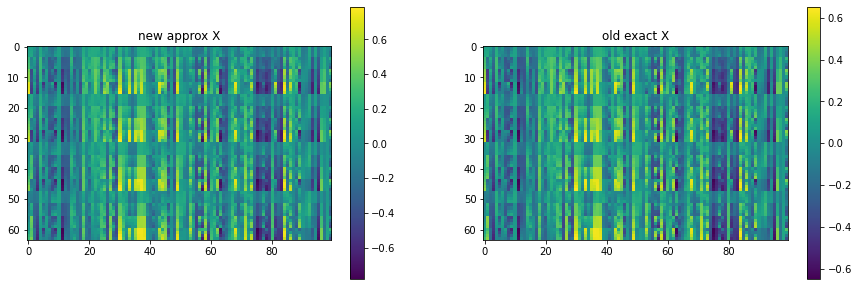

In [178]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.title('new approx X')
plt.imshow(newX.T)#,clim=[-.6,.6])
plt.colorbar()
plt.subplot(1,2,2)
plt.title('old exact X')
plt.imshow(designMatrixX.T)#,clim=[-.6,.6])
plt.colorbar()

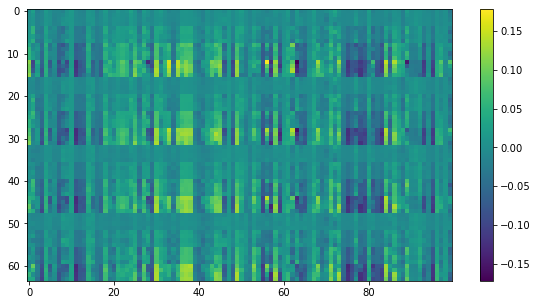

In [179]:
plt.figure(figsize=[10,5])
plt.imshow((newX-designMatrixX).T)
plt.colorbar()

In [180]:
#skip for now...
#meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
#sampsZ = np.random.multivariate_normal(meanZ,covZ,15)
#sampsSource = []
#for s in sampsZ:
#    sampsSource.append(mInfer.computeSourceFromPhi(s))
#sampsSource = np.array(sampsSource)
#uncertainty = np.std(sampsSource,0)

In [181]:
#plt.contour(uncertainty[5,:,:])#,levels=np.arange(0,0.501,0.125)*np.mean(source))
#plt.colorbar()

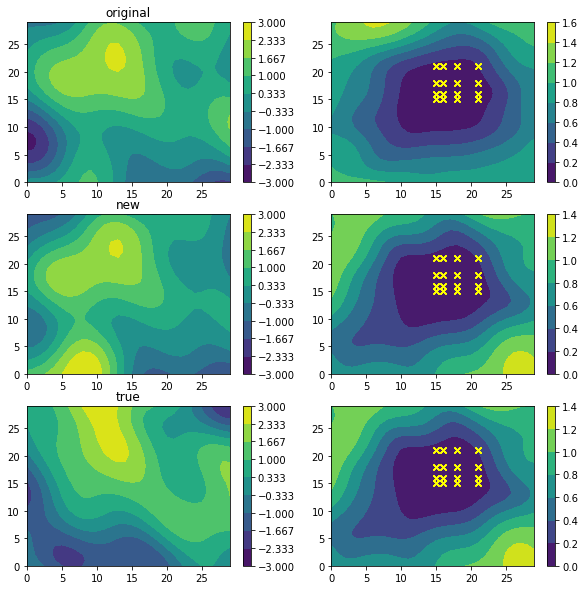

In [182]:
plt.figure(figsize=[10,10])
for plti,(title,useX) in enumerate(zip(['original','new','true'],[designMatrixX,newX,None])):
    mInfer.X = useX
    plt.subplot(3,2,(plti*2)+1)
    plt.title(title)
    #regress = m.computeModelRegressors() # Compute regressor matrix
    if title!='true':
        meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
        sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
    else:
        sourceInfer = source
    #plt.imshow(sourceInfer[5,:,:],clim=[-5,5])
    plt.contourf(sourceInfer[5,:,:],levels=np.linspace(-3,3,10))#clim=[-5,5])
    plt.colorbar()
    #plt.contour(uncertainty[5,:,:])
    plt.subplot(3,2,(plti*2)+2)

    
    if title!='true':
        meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
        Zsamples = np.random.multivariate_normal(meanZ,covZ,size=20)
        samples = []
        for samp in Zsamples:
            samples.append(mInfer.computeSourceFromPhi(samp))
    else:
        sourceInfer = source

        
    S = np.array(samples)
    plt.contourf(np.std(S,0)[5,:,:])
    #plt.imshow(np.std(S,0)[5,:,:])
    plt.colorbar()
    sesnorgridX = mInfer.getGridCoord(X[:,1:])
    plt.scatter(sesnorgridX[:,1],sesnorgridX[:,2],marker='x',color='yellow')

    #plt.ylim([0,3])

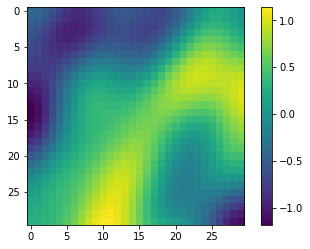

In [183]:
plt.imshow(m.computeConcentration(source)[5,:,:])
plt.colorbar()

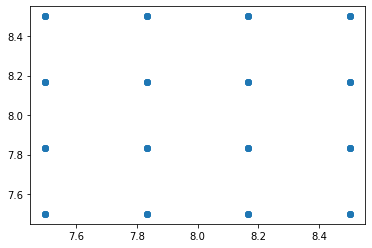

In [154]:
plt.scatter(mInfer.sensormodel.obsLocs[:,2],mInfer.sensormodel.obsLocs[:,3])